In [14]:
%load_ext autoreload
%autoreload 2
%load_ext ipycache

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [55]:
#%%cache -d __cache__/ -f __cache__/eda.pkl eda
# Importing all the required libraries
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, \
                                    StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report
from self_learn import CustomLogisticRegression, BaymaxNet
from utils import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Every data point corresponds to a (time, latitude, longitude) and contains the following 16 atmospherical variables or features:

TMQ: total (vertically integrated) precipitable water [kg/m^2] <br>
U850: zonal wind at 850 mbar pressure surface [m/s] <br>
V850: meridional wind at 850 mbar pressure surface [m/s] <br>
UBOT: lowest level zonal wind [m/s]<br>
VBOT: lowest model level meridional wind [m/s]<br>
QREFHT: reference height humidity [kg/kg]<br>
PS: surface pressure [Pa]<br>
PSL: sea level pressure [Pa]<br>
T200: temperature at 200 mbar pressure surface [K]<br>
T500: temperature at 500 mbar pressure surface [K]<br>
PRECT: total (convective and large-scale) precipitation rate (liq + ice) [m/s]<br>
TS: surface temperature (radiative) [K]<br>
TREFHT: reference height temperature [K]<br>
Z1000: geopotential Z at 1000 mbar pressure surface [m]<br>
Z200: geopotential Z at 200 mbar pressure surface [m]<br>
ZBOT: lowest modal level height [m]<br>

The training set contains 44,760 data points from 1996 to 2009, each labelled according to one of the following three classes:<br>

0: Standard background conditions<br>
1: Tropical cyclone<br>
2: Atmospheric river<br>

In [3]:
df = pd.read_csv('data/train.csv', parse_dates=['time'],index_col='time').drop(['SNo'], axis=1).sort_index()
print('Set Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))
display(df.head())

Set Memory Usage = 6.83 MB


,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,Label
time,,,,,,,,,,,,,,,,,,,
1996-06-09,-21.238592,229.6875,25.438482,-3.247382,-3.297787,-3.043154,-1.810961,0.013082,101599.9453,101599.9453,216.035339,264.645508,2.450000e-08,298.454468,297.187134,138.993042,12285.72070,65.412819,2
1996-06-09,12.790091,252.8125,43.837868,5.089389,1.179331,4.618520,0.982055,0.016696,100964.7422,100964.7422,217.971390,266.708191,2.180000e-08,302.191803,300.737671,85.289642,12370.61523,66.320358,0
1996-06-09,12.790091,253.1250,43.696663,5.407827,1.328541,4.925084,1.316138,0.016764,100956.8906,100956.8906,218.071503,266.759705,1.090000e-08,302.217499,300.810516,84.616669,12370.10352,66.336067,0
1996-06-09,-24.758801,241.2500,28.214071,0.229187,0.159589,-0.297387,-2.568464,0.011950,101915.7656,101915.7656,214.134933,263.829346,1.500000e-14,296.791962,295.528748,165.004898,12240.12402,65.012306,2
1996-06-09,-30.391134,353.4375,28.484495,11.346172,0.782980,9.311885,-2.077185,0.009948,102185.5547,102185.5547,214.340439,254.305695,8.200000e-08,292.216675,291.288086,184.840607,11921.95898,63.974442,2


In [4]:
%store df

Stored 'df' (DataFrame)


In [3]:
df.describe()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
count,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,4.476000e+04,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760,44760.000000
mean,-2.933507,269.270833,34.621980,-0.609818,-0.017271,-2.138797,-0.808013,0.014375,101553.676510,101555.967294,216.829335,264.355844,4.580801e-08,298.344652,296.923570,135.521651,12290.118668,65.384474,2002-05-25 06:37:38.445040256,0.387332
min,-31.095176,229.062500,6.960679,-58.805229,-26.216906,-58.260475,-20.760452,0.004364,96611.601560,96611.601560,208.824249,249.146011,-4.400000e-23,289.330750,285.426666,63.335205,11718.249020,62.433594,1996-06-09 00:00:00,0.000000
25%,-24.582790,241.875000,23.906342,-5.520361,-2.379751,-6.568208,-3.897676,0.011261,101161.437500,101165.013700,215.463791,262.966995,1.410000e-14,295.959228,294.304199,102.716108,12230.382810,64.672365,2000-09-06 00:00:00,0.000000
50%,-3.872229,253.125000,34.779505,-1.707679,0.148625,-2.701227,-0.855717,0.014613,101528.492200,101531.703100,217.109589,265.177933,5.210000e-09,298.752502,297.352692,133.820953,12319.832030,65.482857,2001-09-30 00:00:00,0.000000
75%,21.766623,277.187500,44.321056,3.546206,2.326534,1.663309,2.034851,0.017949,101873.328100,101874.640600,218.367691,266.811386,3.030000e-08,301.767212,300.476807,161.562851,12388.112300,66.329466,2003-07-17 00:00:00,0.000000
max,24.054759,354.375000,80.641357,32.277344,58.060246,30.215387,31.106283,0.022366,103996.953100,103996.953100,229.172897,273.580810,1.440000e-05,303.869812,304.364197,328.123688,12495.289060,67.131653,2009-10-22 00:00:00,2.000000
std,22.906771,41.046619,12.765972,6.866391,4.307206,6.059180,4.786933,0.003951,544.619301,543.672908,2.295840,3.463063,2.448857e-07,3.763268,3.998874,42.355824,129.311333,1.035777,NaN,0.764119


# Check missing data

In [94]:
draw_missing_data_table(df)

,Total,Percent of NaNs
lat,0,0.0
T200,0,0.0
ZBOT,0,0.0
Z200,0,0.0
Z1000,0,0.0
TREFHT,0,0.0
TS,0,0.0
PRECT,0,0.0
T500,0,0.0
PSL,0,0.0


# value counts

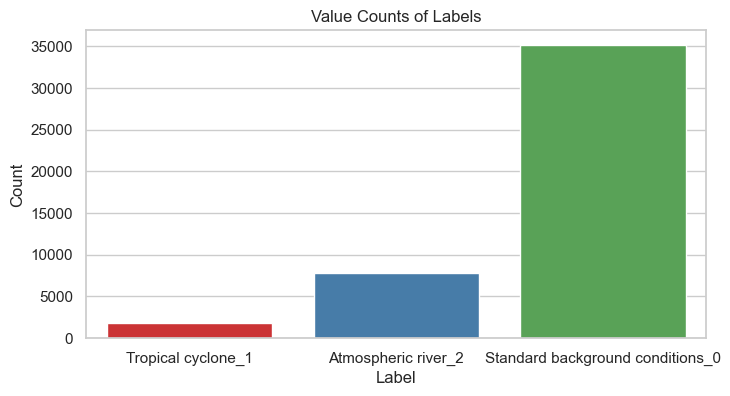

In [79]:
label_mapping = {
    0: 'Standard background conditions_0',
    1: 'Tropical cyclone_1',
    2: 'Atmospheric river_2'
}

# Map the label codes to custom label names
custom_labels = df['Label'].map(label_mapping)

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x=custom_labels, palette='Set1')  # You can change the palette
plt.title('Value Counts of Labels')
plt.ylabel('Count')

plt.show()

In [45]:
# get label percentage
df['Label'].value_counts(normalize=True)

Label
0    0.752510
2    0.202033
1    0.045456
Name: proportion, dtype: float64

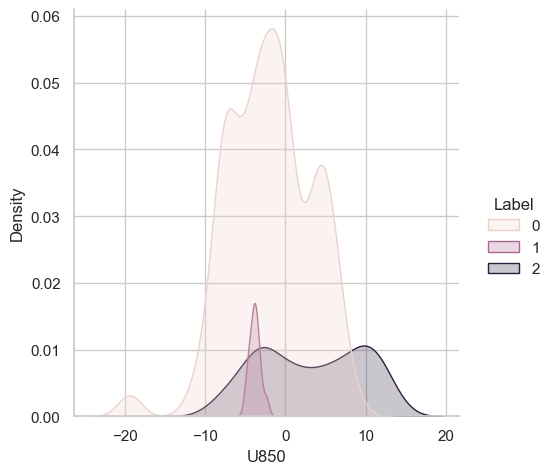

In [50]:
sns.displot(data, x="U850", hue="Label", kind="kde", fill=True)

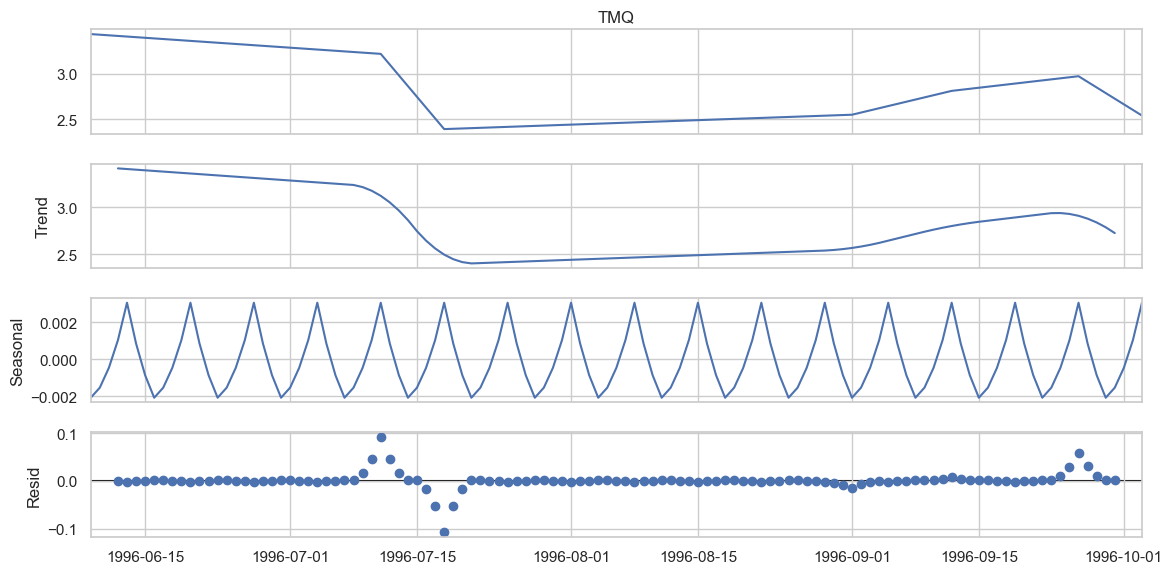

In [52]:
plt.rc('figure', figsize=(12, 6))
plt.rc('font', size=15)

data = df[(df.index.year.isin([1996]))]
mean_resampled_data = data.resample('D').mean()
std_resampled_data = data.resample('D').std()

standardized_data = mean_resampled_data / std_resampled_data

# Handle any missing data
standardized_data = standardized_data.interpolate(method='linear')
result = seasonal_decompose(standardized_data['TMQ'], model='additive')
fig = result.plot()



# Submission

In [53]:
df_test = pd.read_csv('data/test.csv',parse_dates=['time']).set_index('time').sort_index()

[autoreload of self_learn failed: Traceback (most recent call last):
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/microbot/miniconda/envs/eda/lib/python3.11/site-packages/I

In [60]:
X_train, y_train, X_sub= preprocess(train=df,test=df_test.drop('SNo',axis=1),standardize=True)

In [61]:
model = XGBClassifier(
    colsample_bytree = 0.9385812500707504,
    gamma = 0.188570709579355,
    learning_rate = 0.17,
    max_delta_step = 5,
    max_depth = 9,
    min_child_weight = 7, 
    n_estimators = 254, 
    reg_alpha = 0.2791453005653505,
    reg_lambda = 2.9636012865585113, 
    scale_pos_weight = 7.692974658470718, 
    subsample = 0.9514650766399473,
    objective = 'multi:softmax'
)
model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9385812500707504, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.188570709579355,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=5,
              max_depth=9, max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=254,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [62]:
y_sub = model.predict(X_sub.values)

In [63]:
sub = pd.DataFrame({'SNo':df_test['SNo'],'Label':y_sub})
sub.to_csv('data/20231105_xgb3_submission.csv',index=False)